In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from cycler import cycler
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
from matplotlib.ticker import AutoMinorLocator

In [4]:
DF = pd.read_csv('../data/main_table.csv', index_col=0)
DF = DF.loc[DF.w_median.notnull()]

colors = np.array([ '#7e1e9c', '#15b01a', '#0343df', '#653700', '#e50000', '#ff81c0' ])

In [5]:
# plot fontsize settings

SMALL_FONT_SIZE = 22
MEDIUM_FONT_SIZE = 28
LARGE_FONT_SIZE = 28

plt.rc('font', size=SMALL_FONT_SIZE)          # default text sizes
plt.rc('axes', titlesize=LARGE_FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT_SIZE)    # fontsize of the x and y labels
plt.rc('axes', linewidth=2)                   # linewidth of the graph borders
plt.rc('xtick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_FONT_SIZE)   # fontsize of the figure title
plt.rc('axes', prop_cycle=cycler(color=colors))

In [6]:
def line(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    a = (y2-y1)/(x2-x1)
    b = y1 - a*x1
    return lambda x: a * x + b

In [7]:
def cc_region(df):
    line_lower = line((0.7, 0.1), (3.7, 1.5))
    line_upper = line((0.7, 0.5), (2.0, 1.1))
    x = df['psfMag_u'] - df['psfMag_g']
    y = df['psfMag_g'] - df['psfMag_r']
    
    conditions = [
        (x < 0.7) & (y < -0.2),
        (x < 0.7) & (-0.2 <= y) & (y <= 0.5),
        (x < 0.7) & (y > 0.5),
        (x < 2.0) & (y > line_upper(x)),
        (0.7 <= x) & (x <= 1.4) & (y < line_lower(x)),
        (x > 1.4) & (y < line_lower(x))
    ]
    choices = [ 1, 2, 3, 3, 4, 6 ]
    
    return np.select(conditions, choices, default=5)

In [8]:
is_nonvar = DF.nonvar_match_num == 1
is_var    = DF.var_match_num == 1
is_quasar = DF.quasar_match_num == 1

nonvar_subset = DF[is_nonvar & ~is_var & ~is_quasar]
var_subset    = DF[~is_nonvar & is_var & ~is_quasar]
quasar_subset = DF[~is_nonvar & ~is_var & is_quasar]
unambi_subset = pd.concat([nonvar_subset, var_subset, quasar_subset])

In [9]:
def ww_region(df):
    x = df['w_rrms']
    y = df['w_median']
    is_nonvar = df.nonvar_match_num == 1
    is_var    = df.var_match_num == 1
    is_quasar = df.quasar_match_num == 1
    
    conditions = [
        is_nonvar & ~is_var & ~is_quasar & (x > 0.1) & (x < 0.2) & (y < 0.3),
        is_nonvar & ~is_var & ~is_quasar & (x < 0.03) & (y > 0.7) & (y < 0.8),
        is_nonvar & ~is_var & ~is_quasar & (x > 0.15),
        ~is_nonvar & is_var & ~is_quasar & (x > 0.10),
        ~is_nonvar & ~is_var & is_quasar & (x > 0.10)
    ]
    choices = [ 4, 5, 1, 2, 3 ]
    
    return np.select(conditions, choices, default=6)

In [10]:
uMg = DF['psfMag_u'] - DF['psfMag_g']
gMr = DF['psfMag_g'] - DF['psfMag_r']
w_med = DF['w_median']
w_rrms = DF['w_rrms']

cc_region_names = [ 'I', 'II', 'III', 'IV', 'V', 'VI' ]
ww_region_names = '123456'

# All data

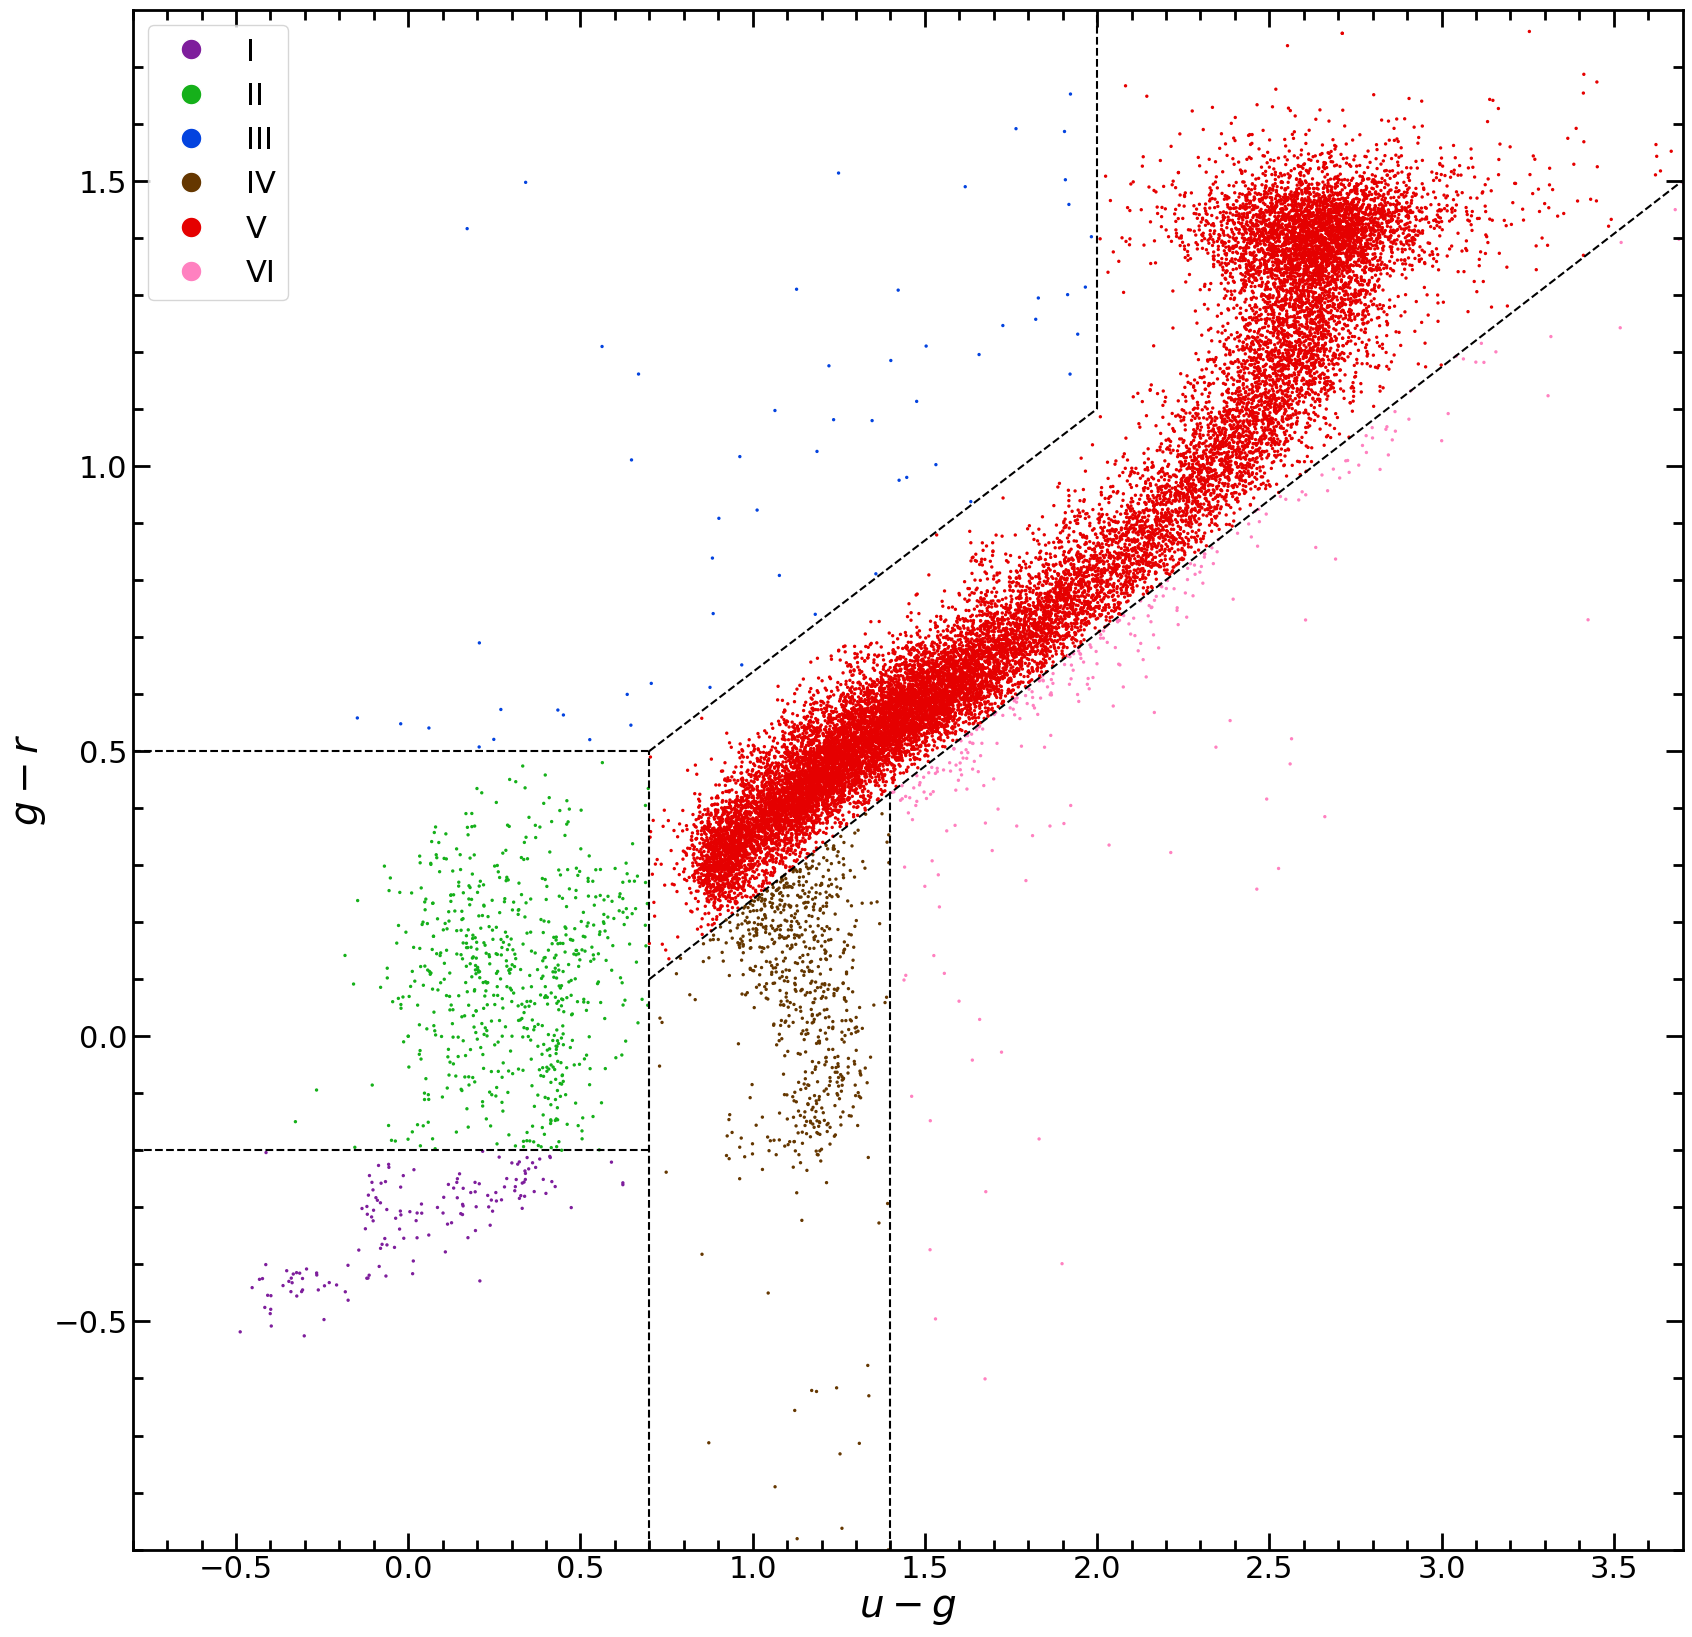

In [11]:
plt.figure(figsize=(20, 20))
sc = plt.scatter(uMg, gMr, s=2, c=colors[cc_region(DF)-1])

plt.xlim(-0.8, 3.7)
plt.ylim(-0.9, 1.8)

plt.xlabel('$u-g$')
plt.ylabel('$g-r$')

# ticks
ax = plt.gca()
ax.tick_params(which='both', width=2, direction='in')
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
ax.tick_params(which='both', top=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

# lines
lines_x = [ (-0.8, 0.7), (-0.8, 0.7), (0.7,),      (1.4,),       (0.7, 3.7), (0.7, 2.0), (2.0,) ]
lines_y = [ (-0.2,),     (0.5,),      (-0.9, 0.5), (-0.9, 0.43), (0.1, 1.5), (0.5, 1.1), (1.1, 1.8) ]
for xs, ys in zip(lines_x, lines_y):
    ax.add_line(Line2D(xs, ys, c='k', ls='--'))

handles = [ Line2D([], [], marker='o', color='w', label=cc_region_names[i], markerfacecolor=colors[i], markersize=15)
           for i in range(len(colors)) ]
ax.legend(handles=handles)

plt.show()

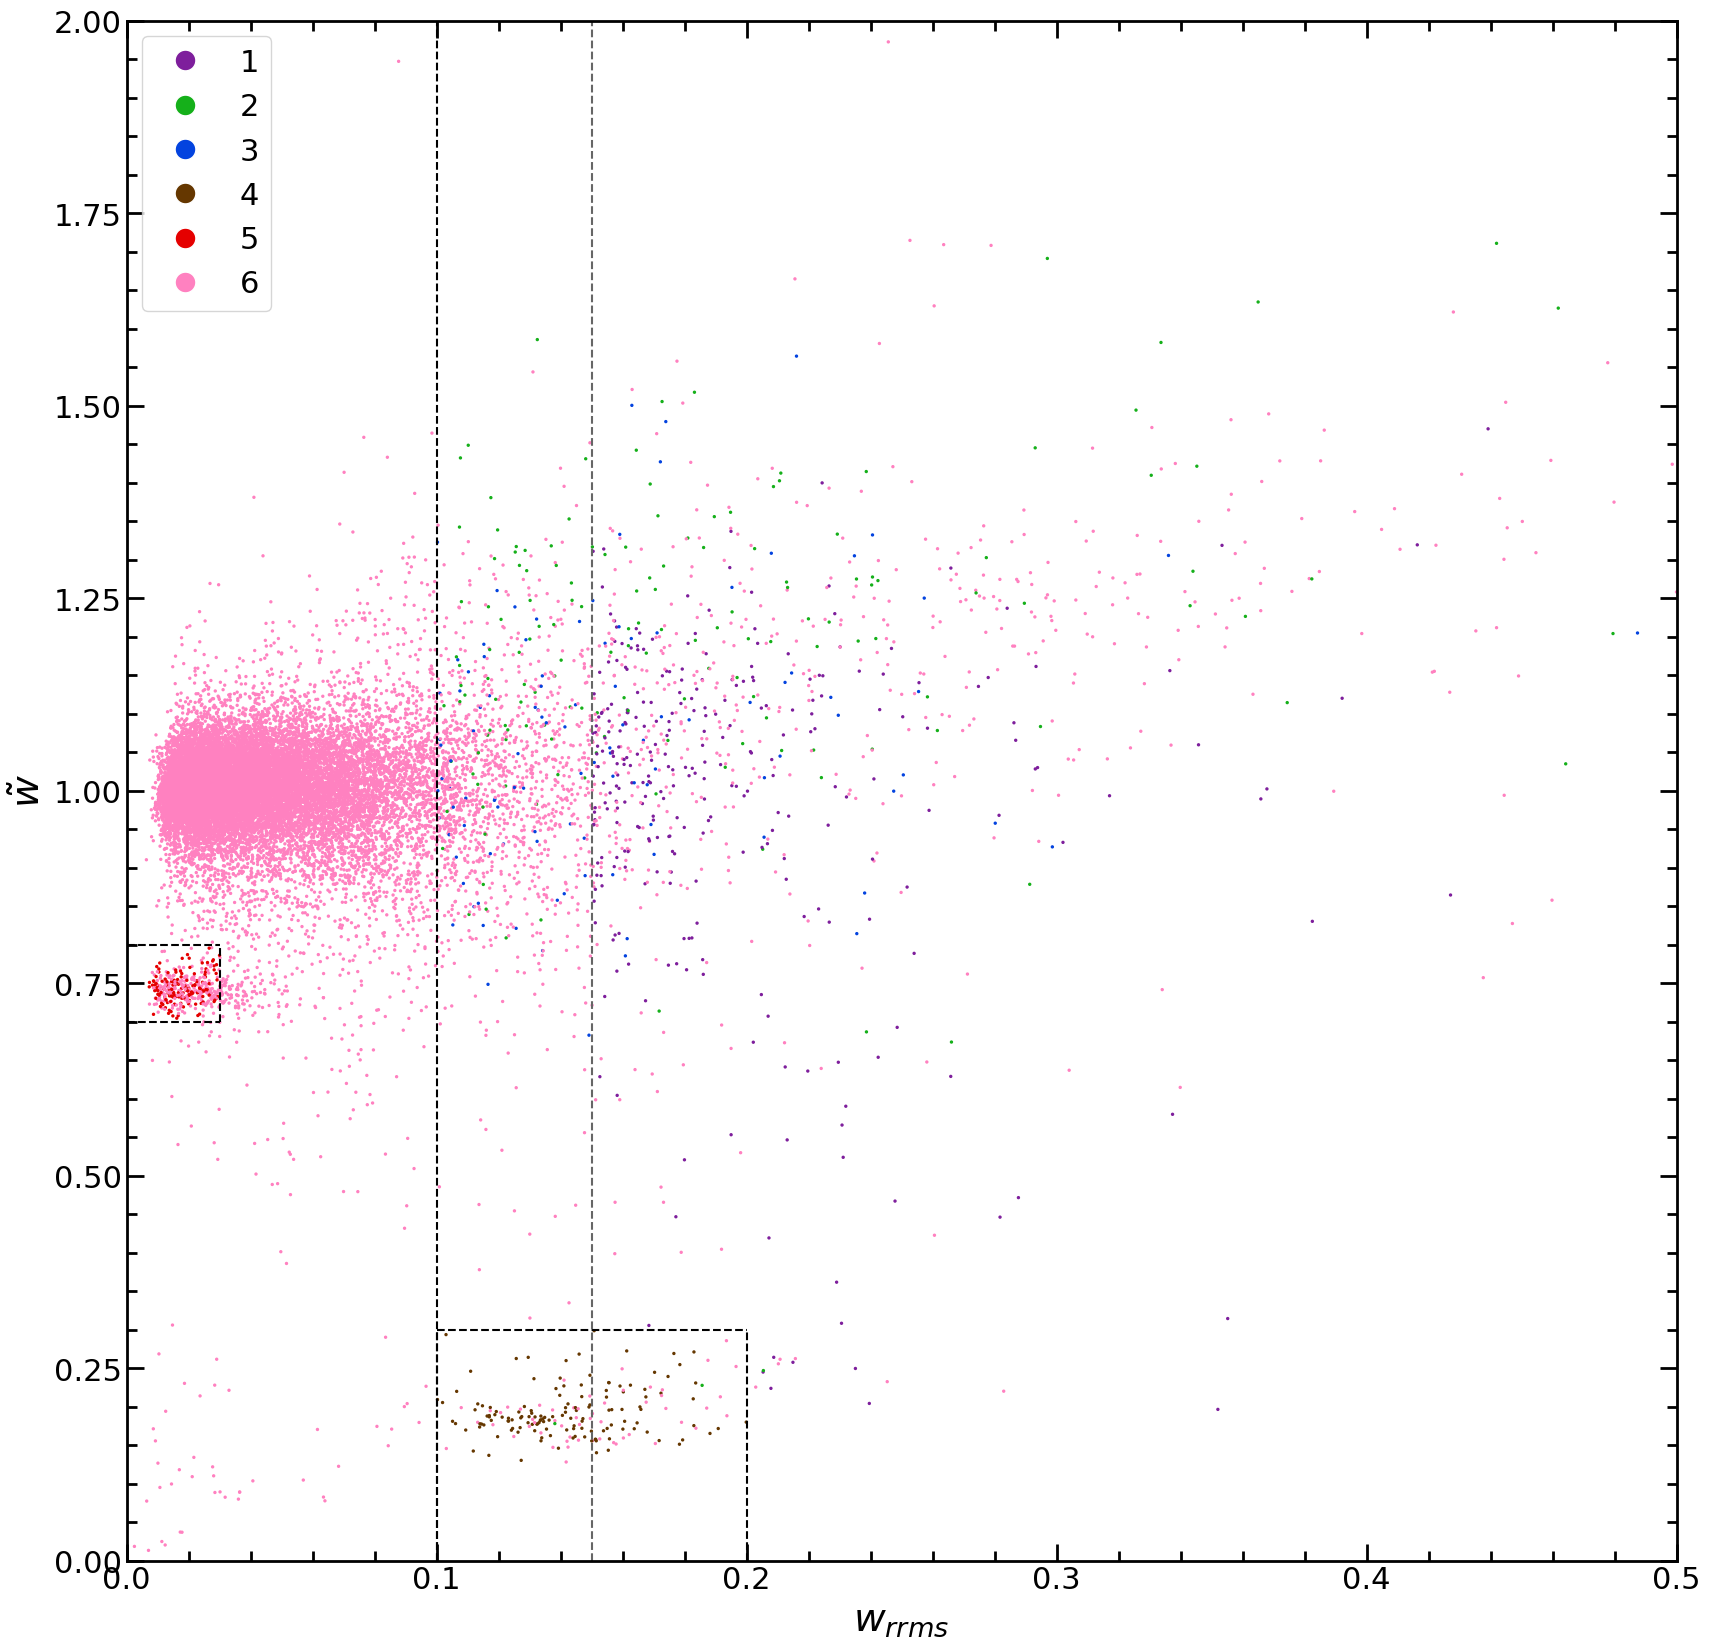

In [12]:
plt.figure(figsize=(20, 20))
plt.scatter(w_rrms, w_med, s=2, c=colors[ww_region(DF)-1])

plt.xlim(0, 0.5)
plt.ylim(0, 2)

plt.xlabel('$w_{rrms}$')
plt.ylabel('$\\tilde{w}$')

# ticks
ax = plt.gca()
ax.tick_params(which='both', width=2, direction='in')
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
ax.tick_params(which='both', top=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

# lines
lines_x = [ (0, 0.03), (0, 0.03), (0.03,),    (0.1,),   (0.2,),   (0.1, 0.2) ]
lines_y = [ (0.8,),    (0.7,),    (0.7, 0.8), (0, 0.3), (0, 0.3), (0.3,)     ]
for xs, ys in zip(lines_x, lines_y):
    ax.add_line(Line2D(xs, ys, c='k', ls='--'))
    
plt.axvline(0.1,  c='#000000', ls='--')
plt.axvline(0.15, c='#666666', ls='--')

handles = [ Line2D([], [], marker='o', color='w', label=ww_region_names[i], markerfacecolor=colors[i], markersize=15)
           for i in range(len(colors)) ]
ax.legend(handles=handles)

plt.show()

# Unambiguously classified data

In [13]:
uMg_u = unambi_subset['psfMag_u'] - unambi_subset['psfMag_g']
gMr_u = unambi_subset['psfMag_g'] - unambi_subset['psfMag_r']
w_med_u = unambi_subset['w_median']
w_rrms_u = unambi_subset['w_rrms']

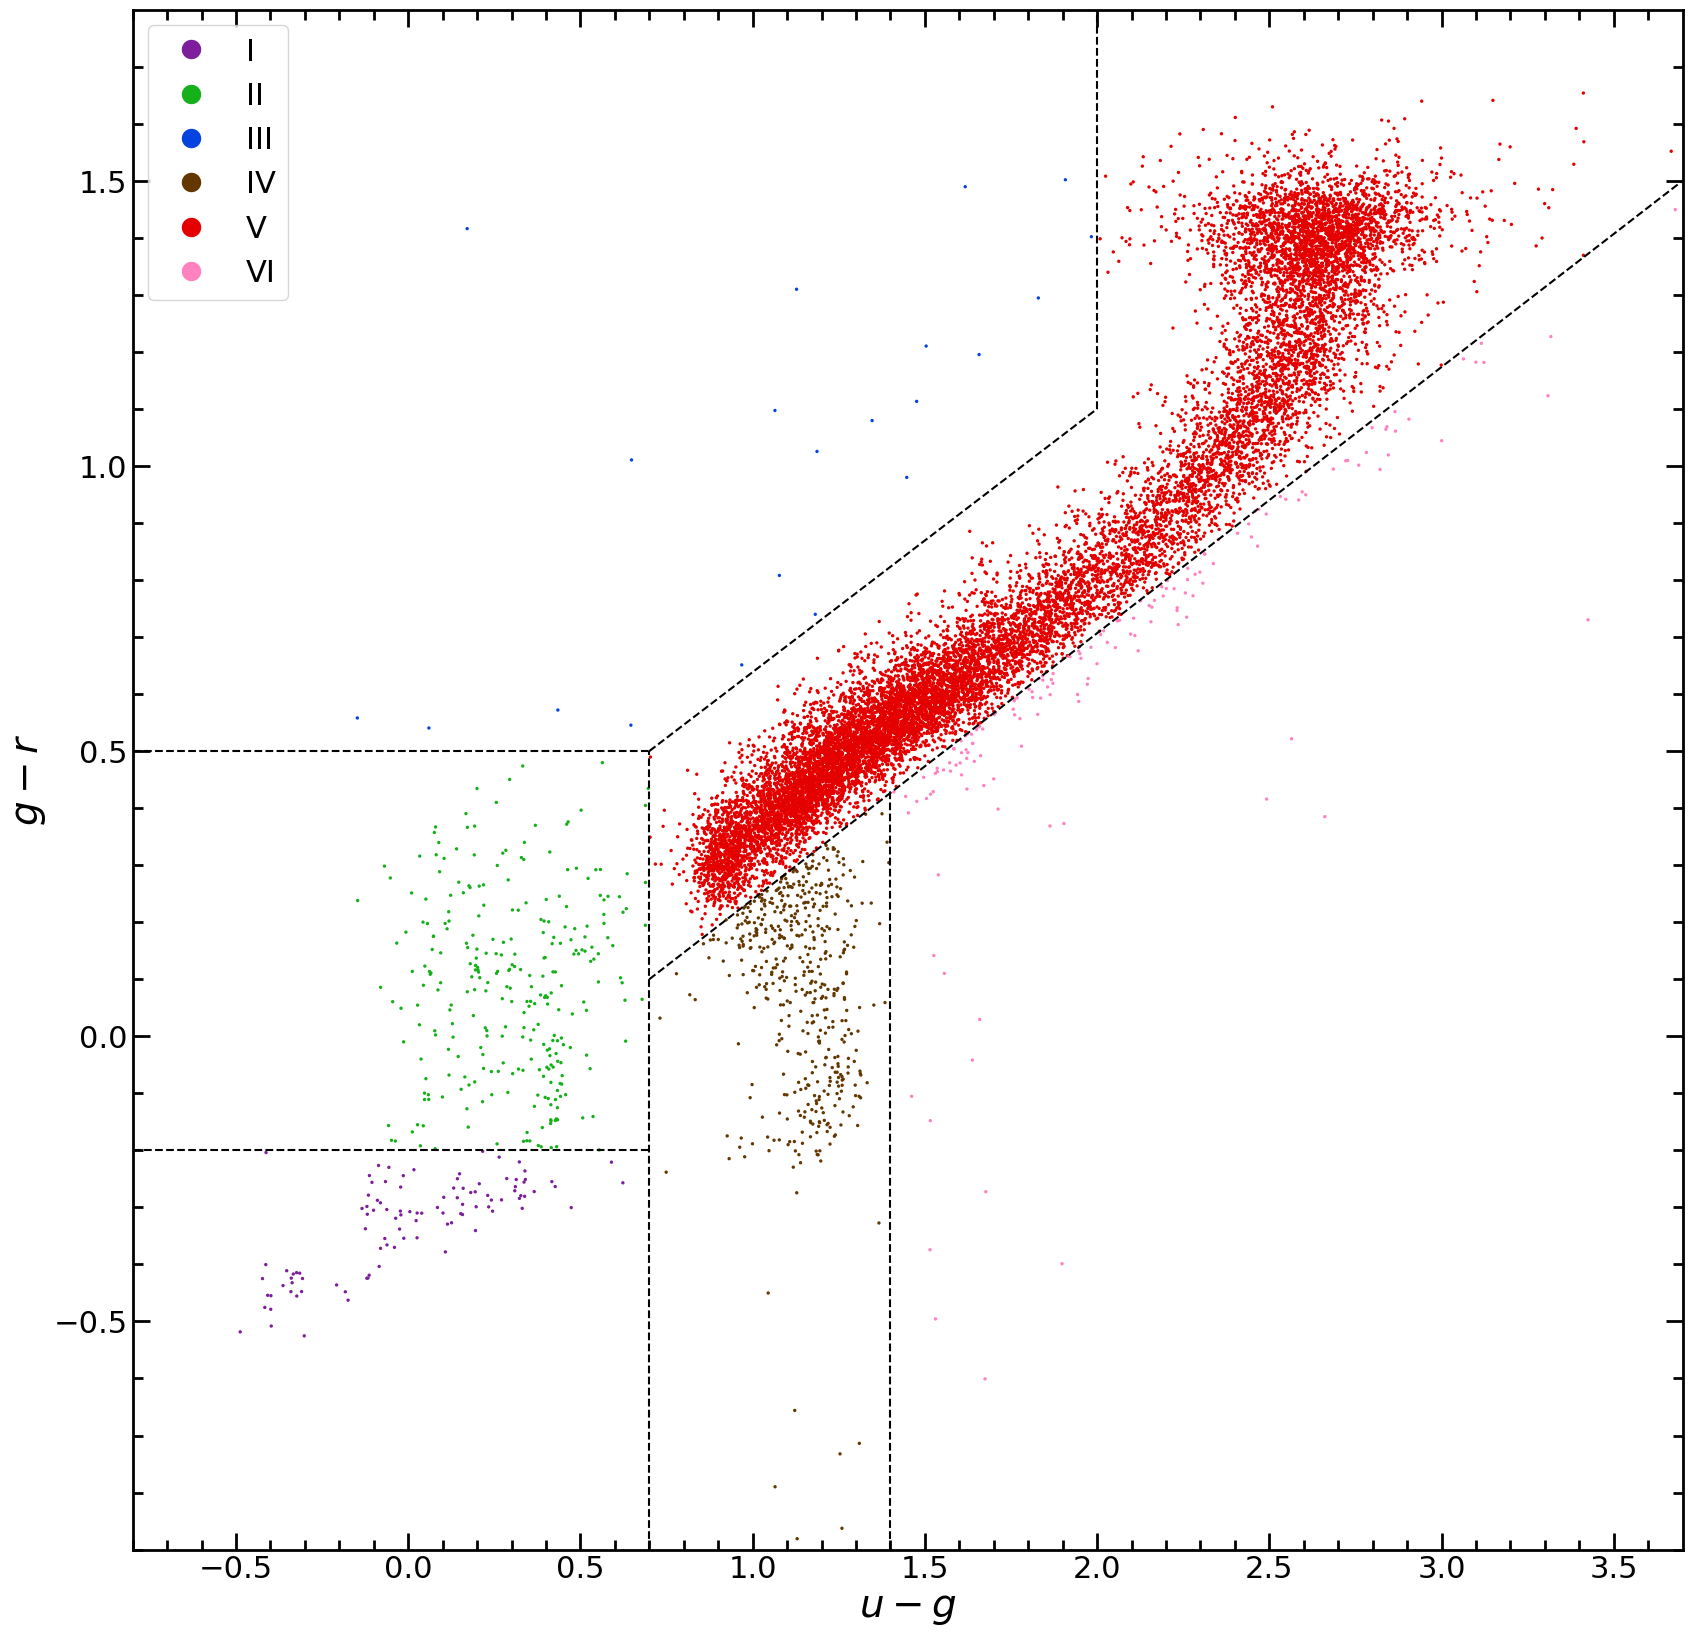

In [14]:
plt.figure(figsize=(20, 20))
sc = plt.scatter(uMg_u, gMr_u, s=2, c=colors[cc_region(unambi_subset)-1])

plt.xlim(-0.8, 3.7)
plt.ylim(-0.9, 1.8)

plt.xlabel('$u-g$')
plt.ylabel('$g-r$')

# ticks
ax = plt.gca()
ax.tick_params(which='both', width=2, direction='in')
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
ax.tick_params(which='both', top=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

# lines
lines_x = [ (-0.8, 0.7), (-0.8, 0.7), (0.7,),      (1.4,),       (0.7, 3.7), (0.7, 2.0), (2.0,) ]
lines_y = [ (-0.2,),     (0.5,),      (-0.9, 0.5), (-0.9, 0.43), (0.1, 1.5), (0.5, 1.1), (1.1, 1.8) ]
for xs, ys in zip(lines_x, lines_y):
    ax.add_line(Line2D(xs, ys, c='k', ls='--'))

handles = [ Line2D([], [], marker='o', color='w', label=cc_region_names[i], markerfacecolor=colors[i], markersize=15)
           for i in range(len(colors)) ]
ax.legend(handles=handles)

plt.show()

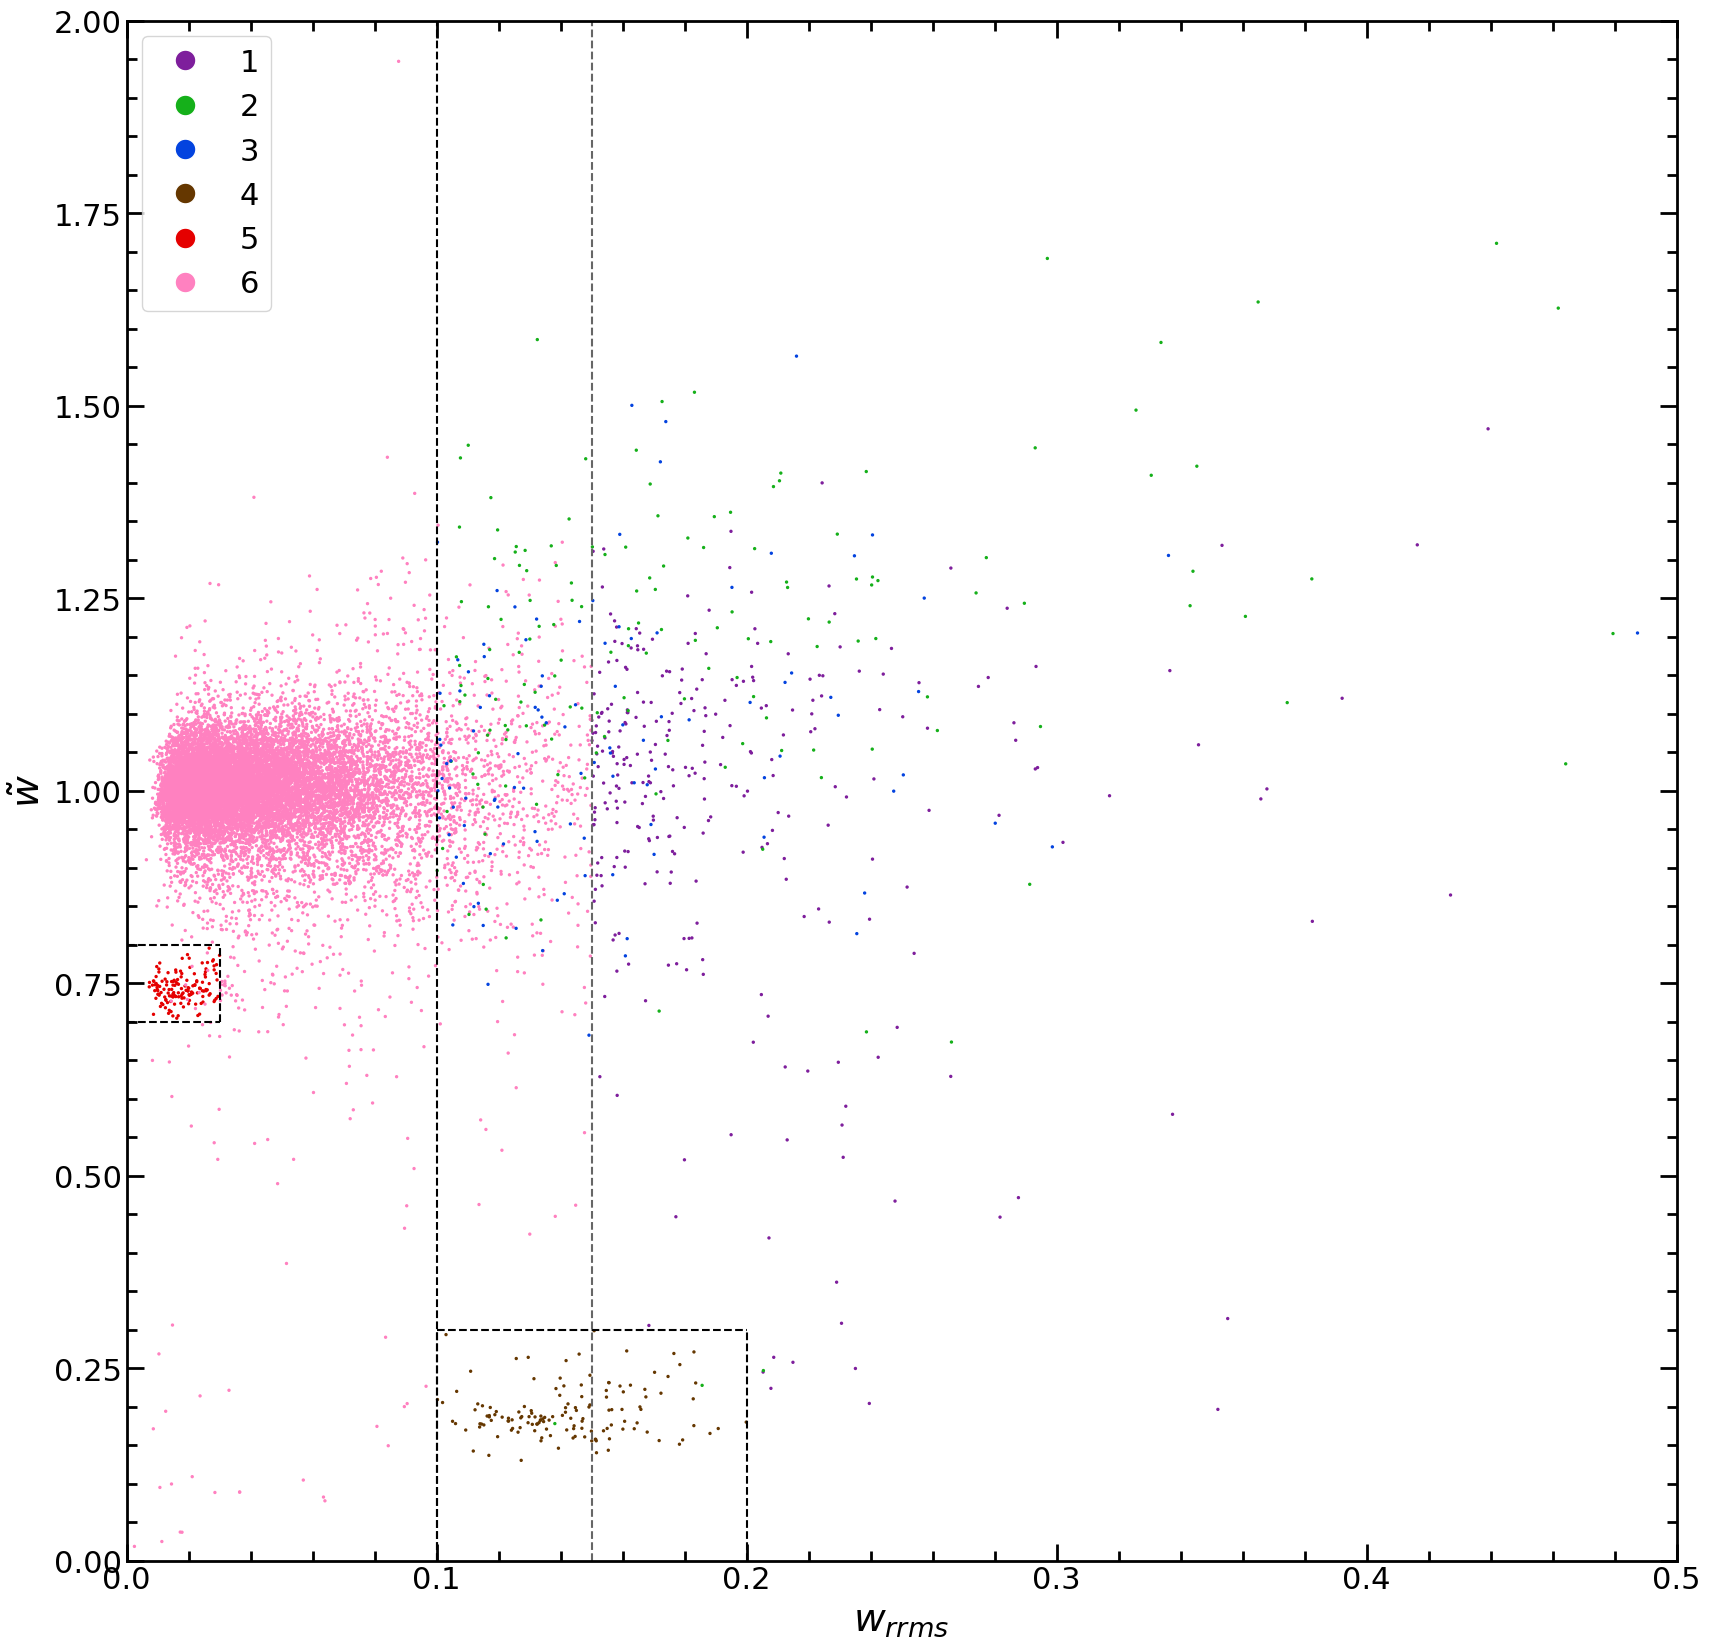

In [15]:
plt.figure(figsize=(20, 20))
plt.scatter(w_rrms_u, w_med_u, s=2, c=colors[ww_region(unambi_subset)-1])

plt.xlim(0, 0.5)
plt.ylim(0, 2)

plt.xlabel('$w_{rrms}$')
plt.ylabel('$\\tilde{w}$')

# ticks
ax = plt.gca()
ax.tick_params(which='both', width=2, direction='in')
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
ax.tick_params(which='both', top=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

# lines
lines_x = [ (0, 0.03), (0, 0.03), (0.03,),    (0.1,),   (0.2,),   (0.1, 0.2) ]
lines_y = [ (0.8,),    (0.7,),    (0.7, 0.8), (0, 0.3), (0, 0.3), (0.3,)     ]
for xs, ys in zip(lines_x, lines_y):
    ax.add_line(Line2D(xs, ys, c='k', ls='--'))
    
plt.axvline(0.1,  c='#000000', ls='--')
plt.axvline(0.15, c='#666666', ls='--')

handles = [ Line2D([], [], marker='o', color='w', label=ww_region_names[i], markerfacecolor=colors[i], markersize=15)
           for i in range(len(colors)) ]
ax.legend(handles=handles)

plt.show()

# ambiguous data

In [107]:
ambi = DF[(is_nonvar & is_var) | (is_nonvar & is_quasar) | (is_var & is_quasar)]

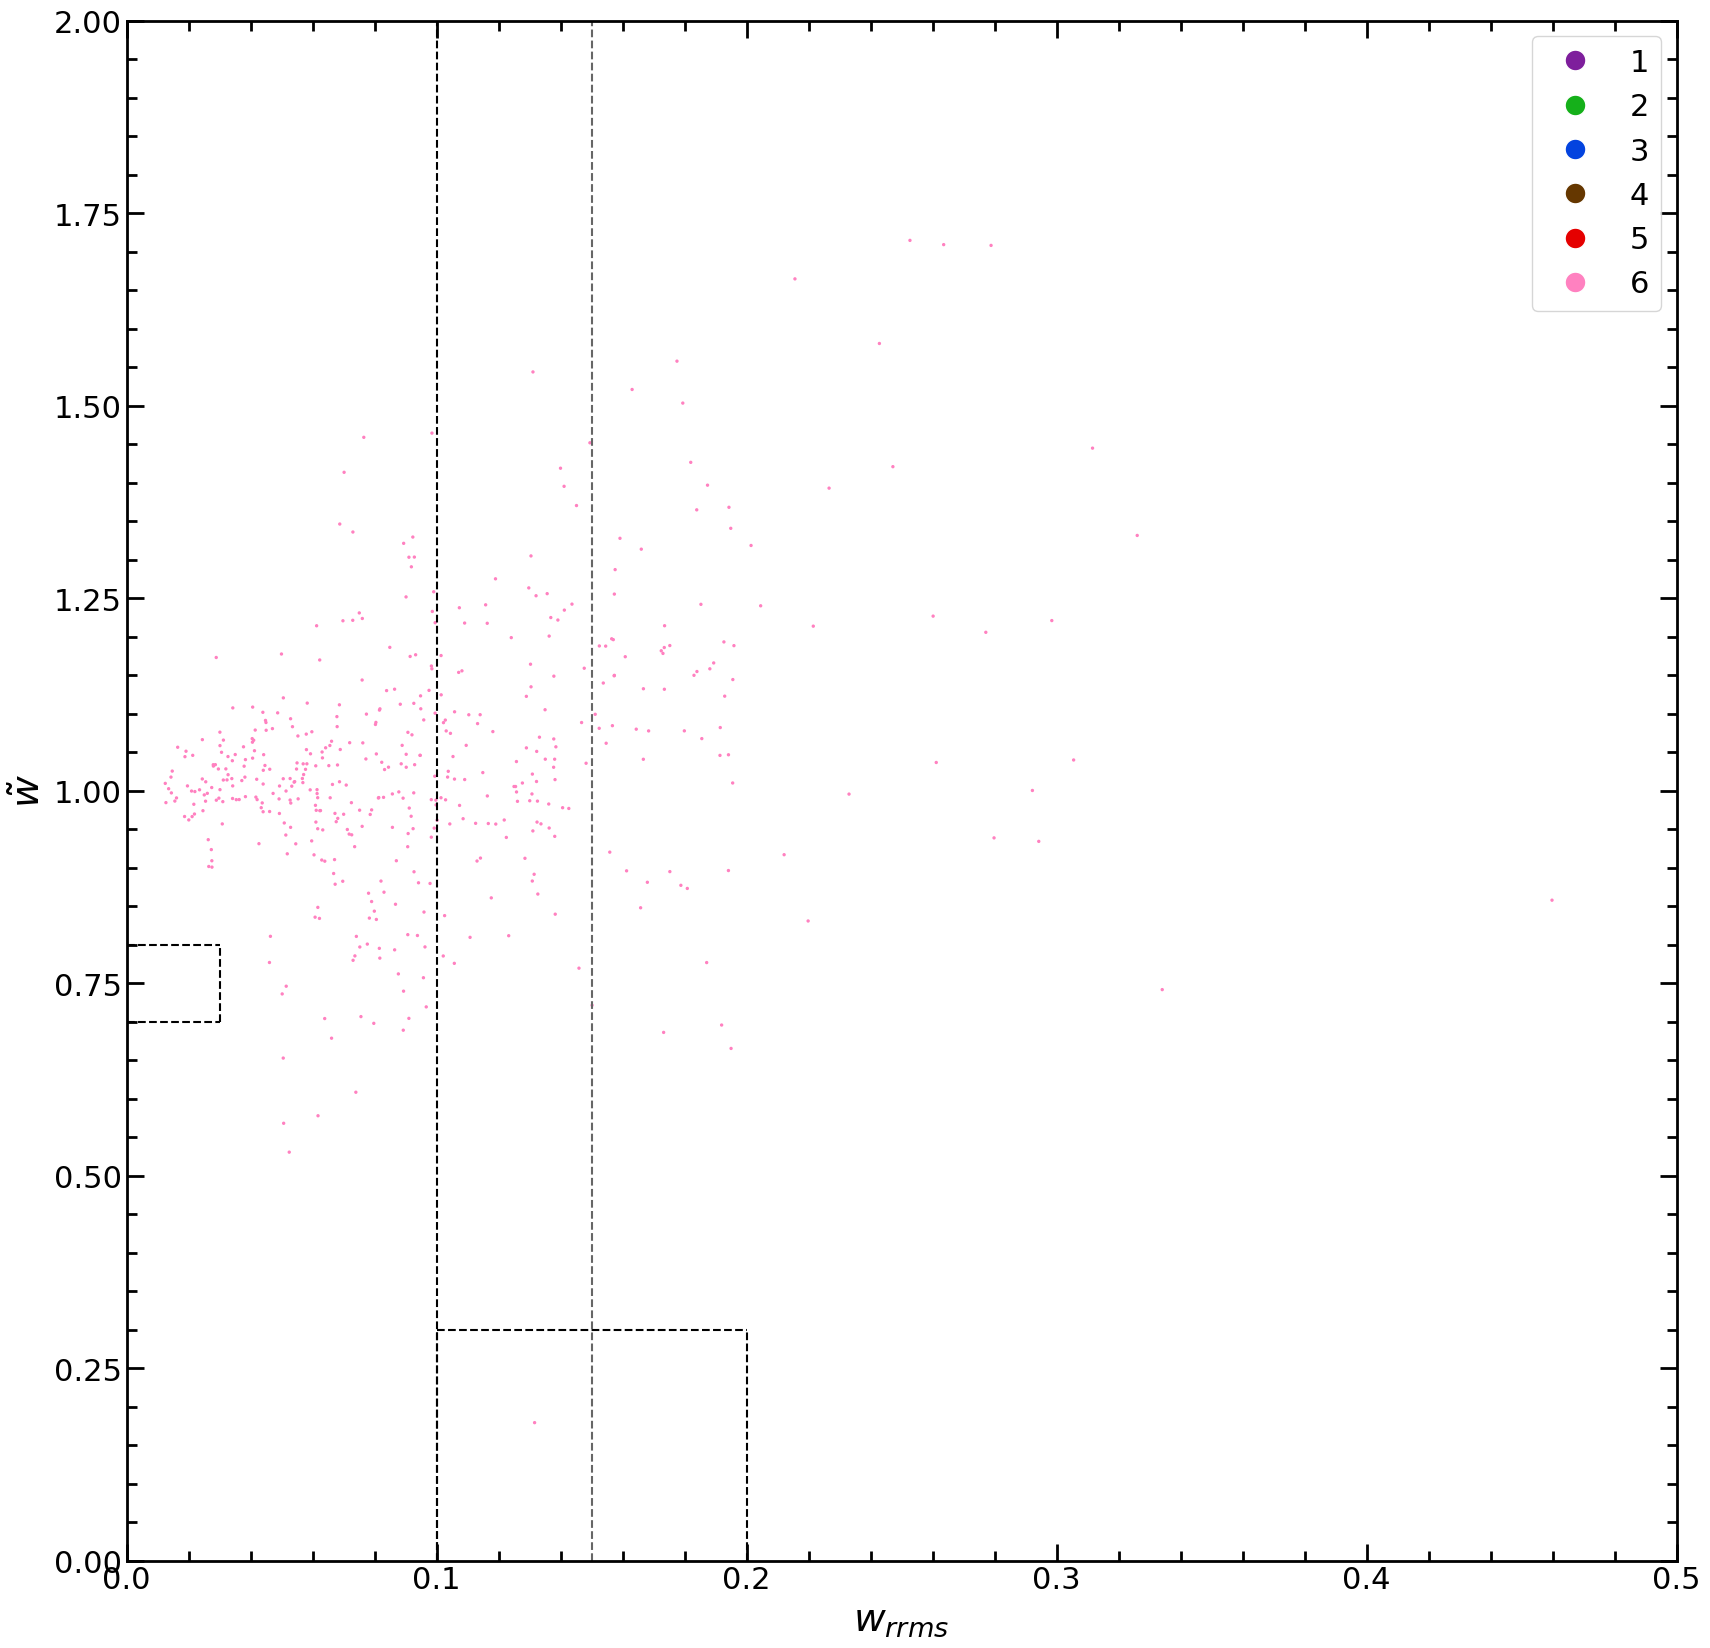

In [108]:
plt.figure(figsize=(20, 20))
plt.scatter(ambi.w_rrms, ambi.w_median, s=2, c=colors[ww_region(ambi)-1])

plt.xlim(0, 0.5)
plt.ylim(0, 2)

plt.xlabel('$w_{rrms}$')
plt.ylabel('$\\tilde{w}$')

# ticks
ax = plt.gca()
ax.tick_params(which='both', width=2, direction='in')
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
ax.tick_params(which='both', top=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

# lines
lines_x = [ (0, 0.03), (0, 0.03), (0.03,),    (0.1,),   (0.2,),   (0.1, 0.2) ]
lines_y = [ (0.8,),    (0.7,),    (0.7, 0.8), (0, 0.3), (0, 0.3), (0.3,)     ]
for xs, ys in zip(lines_x, lines_y):
    ax.add_line(Line2D(xs, ys, c='k', ls='--'))
    
plt.axvline(0.1,  c='#000000', ls='--')
plt.axvline(0.15, c='#666666', ls='--')

handles = [ Line2D([], [], marker='o', color='w', label=ww_region_names[i], markerfacecolor=colors[i], markersize=15)
           for i in range(len(colors)) ]
ax.legend(handles=handles)

plt.show()

# unclassified data

In [16]:
uncl = DF[~(is_nonvar | is_var | is_quasar)]

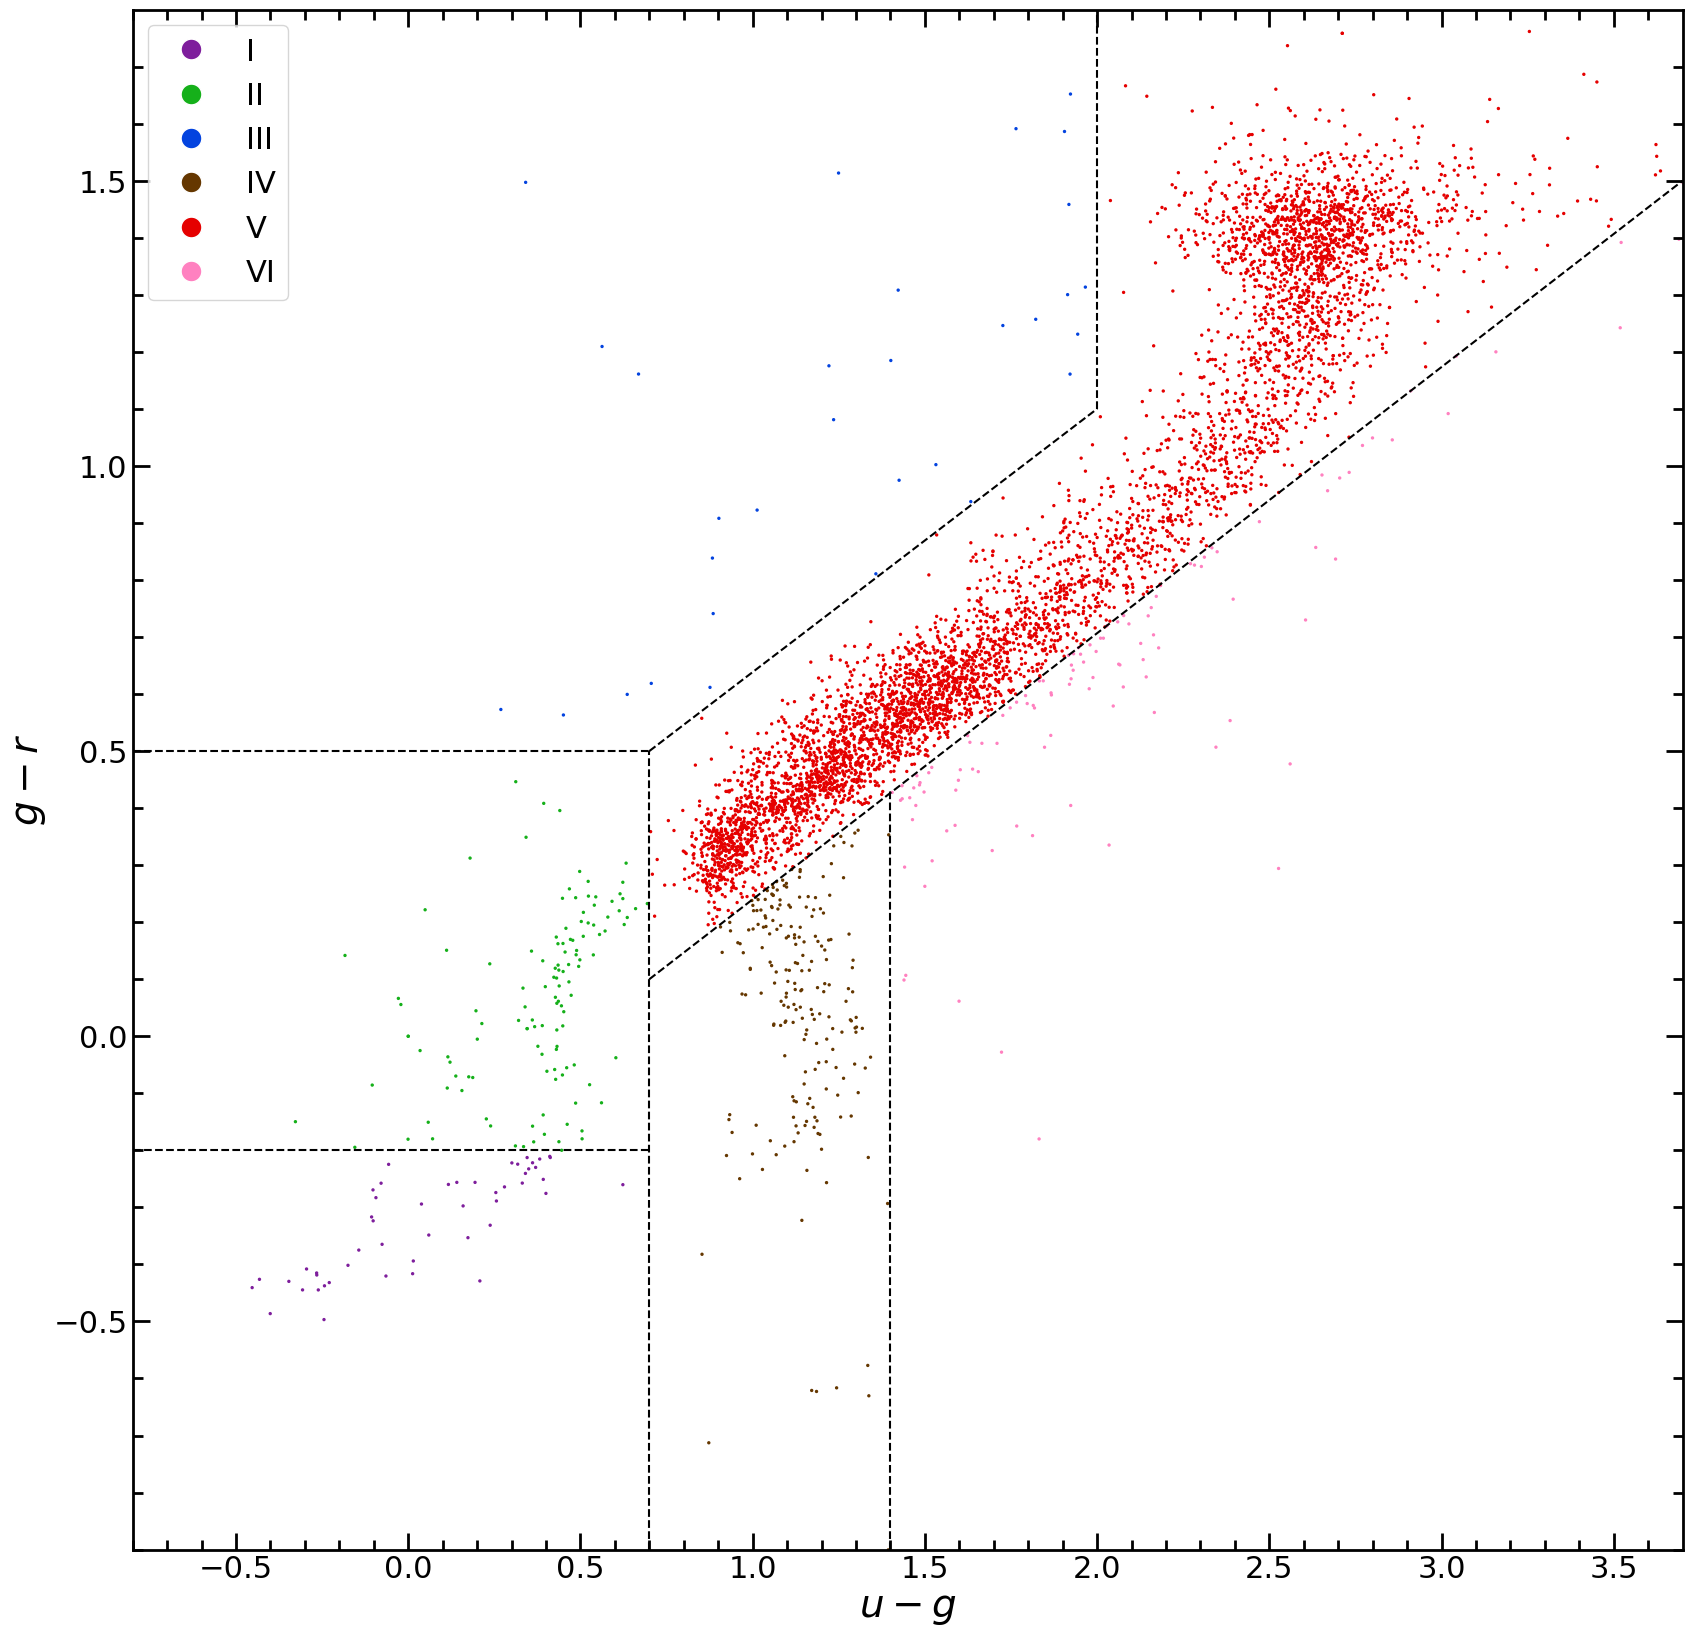

In [17]:
plt.figure(figsize=(20, 20))
sc = plt.scatter(uncl.psfMag_u - uncl.psfMag_g, uncl.psfMag_g - uncl.psfMag_r, s=2, c=colors[cc_region(uncl)-1])

plt.xlim(-0.8, 3.7)
plt.ylim(-0.9, 1.8)

plt.xlabel('$u-g$')
plt.ylabel('$g-r$')

# ticks
ax = plt.gca()
ax.tick_params(which='both', width=2, direction='in')
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
ax.tick_params(which='both', top=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

# lines
lines_x = [ (-0.8, 0.7), (-0.8, 0.7), (0.7,),      (1.4,),       (0.7, 3.7), (0.7, 2.0), (2.0,) ]
lines_y = [ (-0.2,),     (0.5,),      (-0.9, 0.5), (-0.9, 0.43), (0.1, 1.5), (0.5, 1.1), (1.1, 1.8) ]
for xs, ys in zip(lines_x, lines_y):
    ax.add_line(Line2D(xs, ys, c='k', ls='--'))

handles = [ Line2D([], [], marker='o', color='w', label=cc_region_names[i], markerfacecolor=colors[i], markersize=15)
           for i in range(len(colors)) ]
ax.legend(handles=handles)

plt.show()

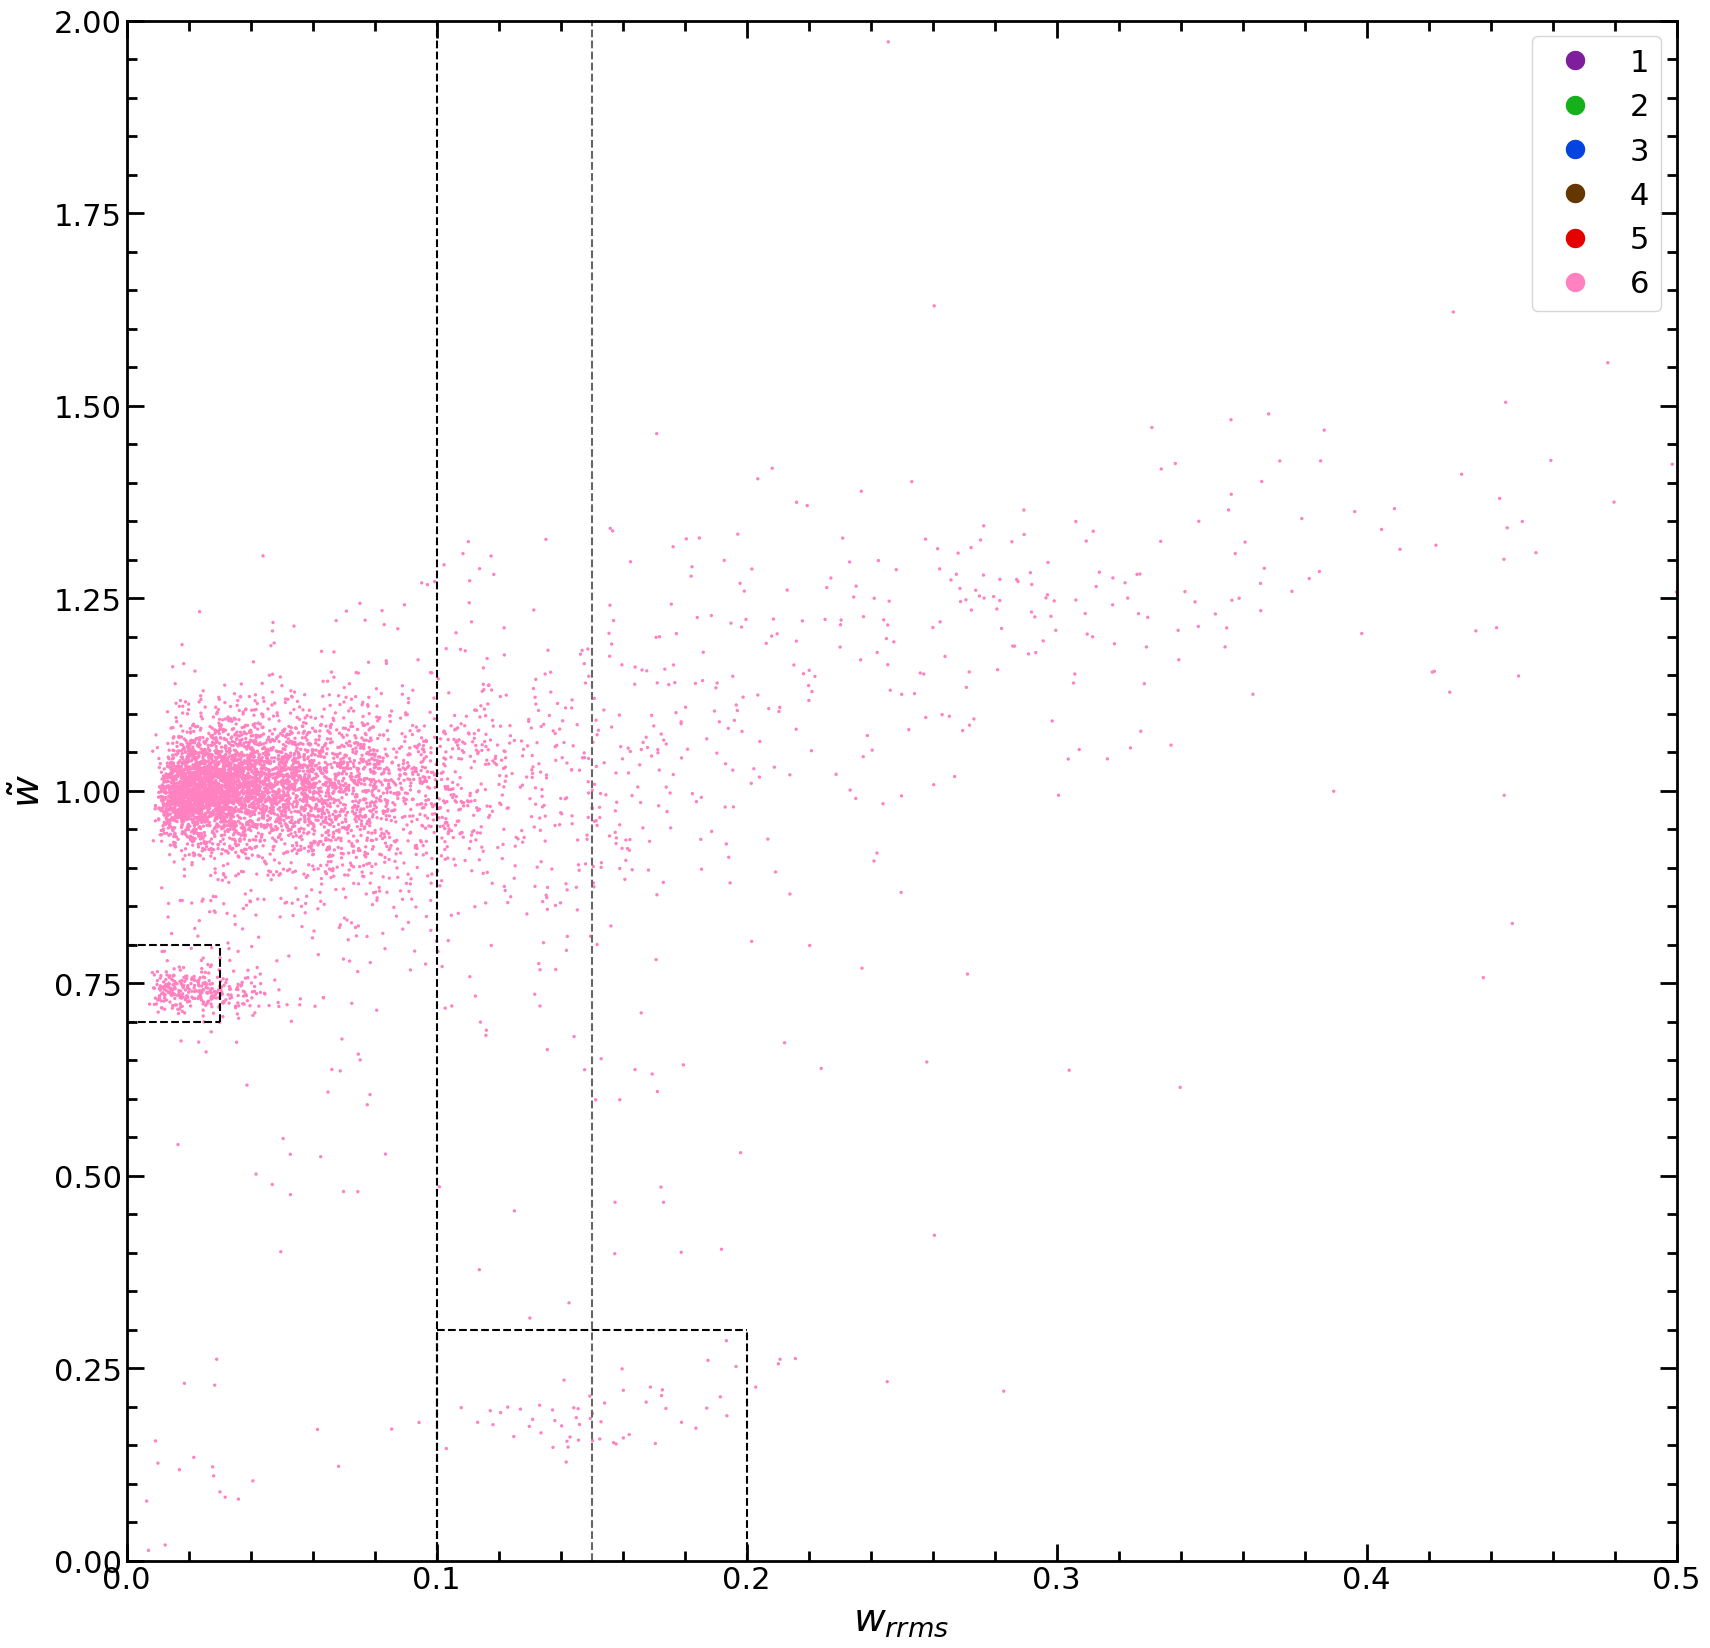

In [110]:
plt.figure(figsize=(20, 20))
plt.scatter(uncl.w_rrms, uncl.w_median, s=2, c=colors[ww_region(uncl)-1])

plt.xlim(0, 0.5)
plt.ylim(0, 2)

plt.xlabel('$w_{rrms}$')
plt.ylabel('$\\tilde{w}$')

# ticks
ax = plt.gca()
ax.tick_params(which='both', width=2, direction='in')
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
ax.tick_params(which='both', top=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

# lines
lines_x = [ (0, 0.03), (0, 0.03), (0.03,),    (0.1,),   (0.2,),   (0.1, 0.2) ]
lines_y = [ (0.8,),    (0.7,),    (0.7, 0.8), (0, 0.3), (0, 0.3), (0.3,)     ]
for xs, ys in zip(lines_x, lines_y):
    ax.add_line(Line2D(xs, ys, c='k', ls='--'))
    
plt.axvline(0.1,  c='#000000', ls='--')
plt.axvline(0.15, c='#666666', ls='--')

handles = [ Line2D([], [], marker='o', color='w', label=ww_region_names[i], markerfacecolor=colors[i], markersize=15)
           for i in range(len(colors)) ]
ax.legend(handles=handles)

plt.show()